In [1]:
from twitter import *
import numpy as np
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models.annotations import LabelSet
from bokeh.models.graphs import from_networkx
from sklearn.cluster import KMeans

In [2]:
with open('auth_dict.txt','r') as f:
    twtr_auth = json.load(f)
# Notice that there are four tokens - you need to create these in the
# Twitter Apps dashboard after you have created your own "app".
CONSUMER_KEY = twtr_auth['consumer_key']
CONSUMER_SECRET = twtr_auth['consumer_secret']
OAUTH_TOKEN = twtr_auth['token']
OAUTH_TOKEN_SECRET = twtr_auth['token_secret']

auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)
t = Twitter(auth=auth)

In [3]:
import sys
import time
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        if e.e.code == 401:
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [4]:
# This will let us create new partial
# functions with arguments set to 
# certain values.
from functools import partial

# This was maxint.
# There is no longer a maxint (in Python 3)
from sys import maxsize


def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                                friends_limit=maxsize, followers_limit=maxsize):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # You can also do this with a function closure.
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                                count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=5000)
    friends_ids, followers_ids = [], []
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        #LOOK HERE! This little line is important.
        if limit == 0: continue
        cursor = -1
        while cursor != 0:
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
            print('Fetched {0} total {1} ids for {2}'.format(len(ids),
                    label, (user_id or screen_name), file=sys.stderr))
            if len(ids) >= limit or response is None:
                break
    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]

In [5]:
# Create a mostly empty data frame,
# and write it to a CSV file.
df = pd.DataFrame(columns=['PID','reciprocal'])
df.to_csv('reciprocals.csv',index=False)

# Our function
def save_followers(fid, reciprocals):
    df = pd.DataFrame([[fid, reciprocals]], columns=['PID','reciprocal'])
    with open('reciprocals.csv', 'a') as f:
        df.to_csv(f,header=False, index=False)

In [6]:
def get_user_profile(twitter_api, screen_names=None, user_ids=None):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None), \
    "Must have screen_names or user_ids, but not both"
    items_to_info = {}
    items = screen_names or user_ids
    while len(items) > 0:
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]
    if screen_names:
        response = make_twitter_request(twitter_api.users.lookup,screen_name=items_str)
    else: # user_ids
        response = make_twitter_request(twitter_api.users.lookup,user_id=items_str)
    
    #print(type(response))

    # Just taking the value of follower's count of the user into consideration as we have to take top-5 reciprocal 
    #follower based on followers count
    for user_info in response:
        if screen_names:
            items_to_info[user_info['screen_name']] = user_info['followers_count'] 
        else: # user_ids
            items_to_info[user_info['id']] = user_info['followers_count']

    info_new={}
    sorted_info={}
    # This is to create a dictionary with key-value as 'followers count' & value as 'id'
    # This will help us to sort the dictionary based on followers count
    for k,v in items_to_info.items():
        info_new[v] = k
    #print(info_new)
    count=0;
    
    #Iterating over sorted dictionary with 'followers count' as key & again converting it to a 'id:followers_count' dictionart
    # and extracting top-5 reciprocal followers
    for key in sorted(info_new.keys(),reverse=True):
        sorted_info[info_new[key]] = key
        count +=1
        if(count == 5):
            break
    #print(sorted_info) This is top-5 id's based on followers-count of the user
    
    # Returning just the id's of the top-5 reciprocal followers
    return list(sorted_info.keys())

In [7]:
def crawl_followers(twitter_api, screen_name, limit=1000000, depth=2):
    
    # Resolve the ID for screen_name and start working with IDs for consistency
    is_hundred=0
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    friends_queue, followers_queue = get_friends_followers_ids(twitter_api, user_id=seed_id,
                        friends_limit=limit, followers_limit=limit)
    
    #print(type(friends_queue))
    #print(type(followers_queue))
    
    next_queue1 = set(friends_queue) & set(followers_queue)
#     print("Reciprocal Friends:")
#     print(next_queue1)
    
    next_queue = get_user_profile(t,user_ids=list(next_queue1))
    print("top-5 reciprocal friends based on their followers_count")
    print(next_queue)   
    
    is_hundred += len(next_queue)
    # Store a seed_id => _reciprocal_ids mapping in MongoDB
    save_followers(seed_id, ','.join([str(x) for x in next_queue]))
    
    print("\n\n\n Inside While Loop:")
    d = 1
    # Note that in the example in the next cell,
    # we never enter this loop.
    while d < depth and is_hundred < 300:  # loop until you reach specified depth & followers count is less than 300
        d += 1
       
        # Reset the next_queue so that we can
        # start building up the next level
        # of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        # Loop through the current
        # level of followers
        for fid in queue:
#             print("total count")
#             print(is_hundred)
            
            if(is_hundred>300):
                break;
            
            friends_queue, followers_queue = get_friends_followers_ids(twitter_api, user_id=fid,
                        friends_limit=limit, followers_limit=limit)
            #print(type(friends_queue))
            #print(type(followers_queue))
    
            next_queue1 = set(friends_queue) & set(followers_queue)
#             print("Reciprocal Friends:")
#             print(next_queue1)
    
            ### Make sure that, length of next_queue1 is greater than zero for before get_user_profile function
            if(len(next_queue1) > 0):
                    next_queue2 = get_user_profile(t,user_ids=list(next_queue1))
                    print("top-5 reciprocal friends based on their followers_count")
                    print(next_queue2)
            
                    # Store an ID with a string recording
                    # IDs of followers of the user with ID "fid"
                    is_hundred += len(next_queue2)
                    save_followers(str(fid), ','.join([str(x) for x in next_queue2]))
                    # Extending the list
                    next_queue += next_queue2
#                     print("my next_queue")
#                     print(next_queue)


In [8]:
# This function is to create the graph from dataframe in which, we have stored id's & their respective reciprocal followers
def createGraph(df):
    G = nx.Graph()
    for index,row in df1.iterrows():
        parent = row['PID']
        # As, PIDs from 2nd index are the ones which were present in reciprocal followers of previous id's
        # This will avoid the duplicating of nodes in the graph
        if(index == 0):             
            G.add_node(parent)
        childs = row['reciprocal'].split(',')
        # Adding all reciprocal followers of the id as nodes
        # Also adding edge between id & their reciprocal followers
        for child in childs:
            G.add_node(int(child))
            G.add_edge(parent,int(child))
    return G   

In [9]:
def plotGraph(G):
    pos = nx.spring_layout(G)
    #nx.draw_networkx(G,pos)
    nx.draw_networkx_nodes(G,pos,
                       nodelist=G.nodes(),
                       node_size=10,
                   alpha=0.8)
    nx.draw_networkx_edges(G,pos)

    plt.show()
#     print("length of Nodes from graph")
#     print(len(G.nodes()))
#     print("Nodes from graph")
#     print(G.nodes())
#     print("Edges from graph")
#     print(G.edges())
    

In [10]:
def plotClusteredGraph(G):
    # This code is for spectral-clustering on the above graph
    A = nx.adjacency_matrix(G)
    D = np.diag(list(dict(nx.degree(G)).values()))
    L = D - A
    lmbds,vctrs = np.linalg.eig(L)
    len(list(nx.components.connected_components(G)))
    indx = [i for i in range(len(lmbds)) if lmbds[i] > .01 and lmbds[i] < .1]
    #indx
    RG_mbd = vctrs[:,indx]
    #RG_mbd
    
    est = KMeans(n_clusters=3)
    #est
    est.fit(RG_mbd)
    labels = est.labels_
    len(labels)
    
    pos = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G,pos,
                       node_color=labels,
                       node_size=10,alpha=0.8)
    nx.draw_networkx_edges(G,pos)
    
    plt.show()    

In [11]:
# screen_name = "timoreilly"
# crawl_followers(t, screen_name, depth=1, limit=10)

In [12]:
screen_name = 'zedshaw'
crawl_followers(t, screen_name, depth=5, limit=5000)

Fetched 987 total friends ids for 15029296
Fetched 5000 total followers ids for 15029296
top-5 reciprocal friends based on their followers_count
[153966123, 5800582, 1500013435, 319769408, 3562121415]



 Inside While Loop:
Fetched 5000 total friends ids for 153966123
Fetched 5000 total followers ids for 153966123
top-5 reciprocal friends based on their followers_count
[60461511, 2419105112, 779379510055763968, 1370645833, 10191772]
Fetched 5000 total friends ids for 5800582
Fetched 5000 total followers ids for 5800582
top-5 reciprocal friends based on their followers_count
[452658911, 4163579753, 41493699, 25949869, 305358151]
Fetched 4969 total friends ids for 1500013435
Fetched 5000 total followers ids for 1500013435
top-5 reciprocal friends based on their followers_count
[29271892, 612155334, 96022517, 785099695895015424, 2836703082]
Fetched 1282 total friends ids for 319769408
Fetched 5000 total followers ids for 319769408
top-5 reciprocal friends based on their followers_count
[2

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 319 total friends ids for 305358151
Fetched 96 total followers ids for 305358151
top-5 reciprocal friends based on their followers_count
[25458378, 5800582, 2842229397, 16347551, 205840429]
Fetched 5000 total friends ids for 29271892
Fetched 5000 total followers ids for 29271892
top-5 reciprocal friends based on their followers_count
[3064348555, 1360142317, 3100655558, 369352648, 888306226764935168]
Fetched 5000 total friends ids for 612155334
Fetched 5000 total followers ids for 612155334
top-5 reciprocal friends based on their followers_count
[2318221211, 3139341697, 1257672565, 3177865126, 14626684]
Fetched 5000 total friends ids for 96022517
Fetched 5000 total followers ids for 96022517
top-5 reciprocal friends based on their followers_count
[722740458758225920, 19226515, 91135990, 305012548, 14262217]
Fetched 5000 total friends ids for 785099695895015424
Fetched 5000 total followers ids for 785099695895015424
top-5 reciprocal friends based on their followers_count
[931232

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 571 total friends ids for 533539874
Fetched 5000 total followers ids for 533539874
top-5 reciprocal friends based on their followers_count
[717313, 285428413, 3562121415, 419487011, 20052487]
Fetched 4329 total friends ids for 150003563
Fetched 5000 total followers ids for 150003563
Fetched 1443 total friends ids for 175541135
Fetched 5000 total followers ids for 175541135
top-5 reciprocal friends based on their followers_count
[143955704]
Fetched 4069 total friends ids for 33440371
Fetched 5000 total followers ids for 33440371
top-5 reciprocal friends based on their followers_count
[212105265, 76121745, 250812631, 91844076, 3193157530]
Fetched 5000 total friends ids for 153966123
Fetched 5000 total followers ids for 153966123
top-5 reciprocal friends based on their followers_count
[60461511, 2419105112, 779379510055763968, 1370645833, 10191772]
Fetched 529 total friends ids for 109431441
Fetched 5000 total followers ids for 109431441
top-5 reciprocal friends based on their fol

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 4644 total friends ids for 322606204
Fetched 5000 total followers ids for 322606204
top-5 reciprocal friends based on their followers_count
[1619910121, 71639139, 201640842, 1101861644, 407481847]
Fetched 1545 total friends ids for 20120818
Fetched 5000 total followers ids for 20120818
Fetched 1890 total friends ids for 46636018
Fetched 5000 total followers ids for 46636018
Fetched 393 total friends ids for 74694859
Fetched 5000 total followers ids for 74694859
Fetched 5000 total friends ids for 63796828
Fetched 5000 total followers ids for 63796828
top-5 reciprocal friends based on their followers_count
[31313277, 764215033, 954927536718282752, 718225089586733056, 2247854208]
Fetched 2328 total friends ids for 225445834
Fetched 5000 total followers ids for 225445834
top-5 reciprocal friends based on their followers_count
[151141544]
Fetched 5000 total friends ids for 243474426
Fetched 5000 total followers ids for 243474426
top-5 reciprocal friends based on their followers_coun

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 5000 total friends ids for 23603092
Fetched 5000 total followers ids for 23603092
top-5 reciprocal friends based on their followers_count
[325076723, 2289100194, 733227625, 317449391, 3433111882]
Fetched 5000 total friends ids for 824659850
Fetched 5000 total followers ids for 824659850
top-5 reciprocal friends based on their followers_count
[826931454219321344, 4179047422, 465369605, 801528769831927808, 2324662781]
Fetched 5000 total friends ids for 1345609681
Fetched 5000 total followers ids for 1345609681
top-5 reciprocal friends based on their followers_count
[851316548, 164386441, 1465030585, 125517500, 241962713]
Fetched 5000 total friends ids for 872695783
Fetched 5000 total followers ids for 872695783
top-5 reciprocal friends based on their followers_count
[113934335, 1045594087, 922406389850390528, 812546141866770432, 3312877527]
Fetched 5000 total friends ids for 444389361
Fetched 5000 total followers ids for 444389361
top-5 reciprocal friends based on their followers

In [13]:
df1 = pd.read_csv('reciprocals.csv')
#df1

,PID,reciprocal
0,15029296,"153966123,5800582,1500013435,319769408,3562121415"
1,153966123,"60461511,2419105112,779379510055763968,1370645..."
2,5800582,"452658911,4163579753,41493699,25949869,305358151"
3,1500013435,"29271892,612155334,96022517,785099695895015424..."
4,319769408,"25084660,15934076,20643592,49708023,39804874"
5,3562121415,"369093749,199482756,1027176686,264050862,53353..."
6,60461511,"150003563,175541135,33440371,153966123,109431441"
7,2419105112,"153966123,111897759,73774244,750833357542584320"
8,779379510055763968,"153966123,618457134,290634863,7468579523221626..."
9,1370645833,"322606204,20120818,46636018,74694859,63796828"


C:\Users\Vishal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


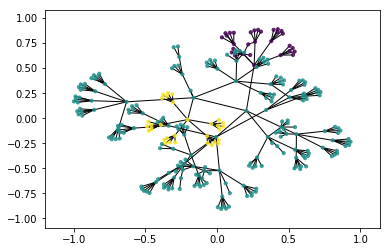

In [14]:
G = createGraph(df1) # Creating the graph from the data of dataframe which is created by reading reciprocal.csv file
                     # which was generated by crawl_followers method
#plotGraph(G)        # I have used this function to check whether graph is build correctly or not before implementing clustering
plotClusteredGraph(G)